# Germinal center: chromatin based cell type detection: 
---
## Unsupervised clustering


Data (from Claudio, IFOM): 
10 images depicting germinal centers (annotated by hand) stained for Dapi, CD3 and AICDA (dataset_1).

In [1]:
# import libraries
import sys
sys.path.append("..")

from pathlib import Path
from glob import glob
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
import _pickle as cPickle
import matplotlib.pyplot as plt
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

from src.utils.cell_type_detection import get_postive_cells_batch,t_cell_neighbours
from src.utils.data_viz import plot_feature_space, vis_classes

from src.utils.data_processing import (
    clean_data,
    remove_correlated_features
)

from src.utils.data_processing import (
    clean_data,
    remove_correlated_features
)

from src.utils.discrimination import (
    compute_cv_scores,
    plot_cv_conf_mtx,
    plot_feature_importance, 
    find_markers, 
    plot_conf_mtx
)
from sklearn.metrics import confusion_matrix, classification_report
from tifffile import imread

seed = 1234

In [2]:
# read in the data
path_to_raw_images = '/media/pathy_s/54fe7289-2a61-4f3a-ac84-eeea3c0d1d2f/ifom_germinal_centers/dataset_1/' 
data_dir = path_to_raw_images + "consolidated_data/"

nuc_features = pd.read_csv(os.path.join(data_dir, "nuc_features.csv"), index_col=0)
spatial_cord = pd.read_csv(os.path.join(data_dir, "spatial_coordiates.csv"), index_col=0)
spatial_cord.index= spatial_cord['nuc_id']

aicda_levels = pd.read_csv(os.path.join(data_dir, "aicda_levels.csv"), index_col=0)
cd3_levels = pd.read_csv(os.path.join(data_dir, "cd3_levels.csv"), index_col=0)
gc_levels = pd.read_csv(os.path.join(data_dir, "gc_levels.csv"), index_col=0)

output_dir = '/media/pathy_s/54fe7289-2a61-4f3a-ac84-eeea3c0d1d2f/ifom_germinal_centers/code/analysis_resources/clustering/'
Path(output_dir).mkdir(parents=True, exist_ok=True)


## Assign cell types


In [3]:
# get postive cell ids
(_, fovs) = pd.factorize(gc_levels['image'].astype("category"))
img_names = fovs.categories

aicda_postive_cells = get_postive_cells_batch(aicda_levels, img_names)
cd3_postive_cells = get_postive_cells_batch(cd3_levels, img_names)
gc_postive_cells = gc_levels[gc_levels['int_mean']>0]['nuc_id'].tolist()

nuc_features.loc[:,'aicda_status'] = 'negative'
nuc_features.loc[nuc_features['nuc_id'].isin(aicda_postive_cells), 'aicda_status'] ='positive'
nuc_features.loc[:,'cd3_status'] = 'negative'
nuc_features.loc[nuc_features['nuc_id'].isin(cd3_postive_cells), 'cd3_status'] ='positive'
nuc_features.loc[:,'gc_status'] = 'negative'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_postive_cells), 'gc_status'] ='positive'

double_positive_cells = list(set(cd3_postive_cells) & set(aicda_postive_cells))
double_negative_cells = list(set(nuc_features['nuc_id']) - set(aicda_postive_cells).union(set(cd3_postive_cells)))

In [4]:
print ( "Number of cells :" + str(len(nuc_features['nuc_id'])))
print ( "Number of germinal center (gc) cells :" + str(len(gc_postive_cells)))

print ( "Number of acida positive cells :" + str(len(aicda_postive_cells)))
print ( "Number of cd3 positive cells :" + str(len(cd3_postive_cells)))

print ( "Number of acida positive cells in the gc :" + str(len(list(set(aicda_postive_cells) & set(gc_postive_cells)))))
print ( "Number of cd3 positive cells in the gc :" + str(len(list(set(cd3_postive_cells) & set(gc_postive_cells)))))

print ( "Number of cd3 and aicda positive cells :" + str(len(list(set(cd3_postive_cells) & set(aicda_postive_cells)))))
print ( "Number of cd3 and aicda positive cells in gc :" + str(len(list(set(cd3_postive_cells) & set(aicda_postive_cells)  & set(gc_postive_cells)))))

print ( "Number of double negative cells :" + str(len(double_negative_cells)))
print ( "Number of double negative cells in gc :" + str(len(list(set(double_negative_cells) & set(gc_postive_cells)))))

Number of cells :57179
Number of germinal center (gc) cells :25622
Number of acida positive cells :10676
Number of cd3 positive cells :21350
Number of acida positive cells in the gc :8892
Number of cd3 positive cells in the gc :3304
Number of cd3 and aicda positive cells :1879
Number of cd3 and aicda positive cells in gc :543
Number of double negative cells :27032
Number of double negative cells in gc :13969


In [5]:
dark_b_cells = list(set(aicda_postive_cells) - set(double_positive_cells))
gc_dark_b_cells = list(set(dark_b_cells) & set(gc_postive_cells))

t_cells = list(set(cd3_postive_cells) - set(double_positive_cells))
gc_t_cells = list(set(t_cells) & set(gc_postive_cells))

light_b_cells = double_negative_cells
gc_light_b_cells = list(set(double_negative_cells) & set(gc_postive_cells))

nuc_features.loc[:,'type'] = 'none'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_dark_b_cells), 'type'] = 'dark_b_cells'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_t_cells), 'type'] = 't_cells'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_light_b_cells), 'type'] = 'light_b_cells'

In [6]:
print ( "Number of dark b cells :" + str(len(dark_b_cells)))
print ( "Number of dark b cells in gc:" + str(len(gc_dark_b_cells)))

print ( "Number of t cells :" + str(len(t_cells)))
print ( "Number of t cells in gc:" + str(len(gc_t_cells)))

print ( "Number of light b cells :" + str(len(light_b_cells)))
print ( "Number of light b cells in gc:" + str(len(gc_light_b_cells)))


Number of dark b cells :8797
Number of dark b cells in gc:8349
Number of t cells :19471
Number of t cells in gc:2761
Number of light b cells :27032
Number of light b cells in gc:13969


In [7]:
tcell_neigh = t_cell_neighbours(nuc_features)
gc_tcell_neigh = list((set(tcell_neigh)-set(t_cells)) & set(gc_postive_cells))
gc_outside_zone = list((set(gc_dark_b_cells).union(set(gc_dark_b_cells)) - set(gc_tcell_neigh)))

nuc_features.loc[:,'stage'] = 'none'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_tcell_neigh), 'stage'] = 'within_t_cell_zone'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_outside_zone), 'stage'] = 'outside_t_cell_zone'

print ( "Number of bcells within t-cell zone of influence:" + str(len(gc_tcell_neigh)))
print ( "Number of bcells outside of t-cell zone of influence:" + str(len(gc_outside_zone)))

Number of bcells within t-cell zone of influence:16634
Number of bcells outside of t-cell zone of influence:2406


In [8]:
#save dataset
nuc_features.to_csv(output_dir+"/" +"nuc_features_with_cell_types.csv")


### Cleaning the dataset 

Next, we will ensure that all metadata columns are non-numeric. Then we remove highly correlated features and incomplete rows

In [9]:
# columns to remove
meta_columns = [
    "label",
    "weighted_centroid-0",
    "weighted_centroid-1",
    "centroid-0",
    "centroid-1",
    "bbox-0",
    "bbox-1",
    "bbox-2",
    "bbox-3",
    "nuc_id"
    "image",
    "orientation",
    "aicda_status",
    "cd3_status",
    "gc_status"
]
nuc_meta_columns = set(meta_columns).intersection(nuc_features.columns)
nuc_features.loc[:, nuc_meta_columns] = np.array(nuc_features.loc[:, nuc_meta_columns]).astype(
    "str"
)
nuc_features.index = nuc_features.nuc_id
nuc_to_remove = list(set(nuc_features['nuc_id'][nuc_features['type'] == 'none']) & 
                     set(nuc_features['nuc_id'][nuc_features['stage'] == 'none']))

cleaned_nuc_feat = nuc_features.drop(nuc_to_remove, axis = 0)

In [10]:
cleaned_nuc_feat = clean_data(cleaned_nuc_feat, index_col="nuc_id")

Removed 19 constant or features with missing values. Remaining: 178.
Removed additional 0 features. Remaining: 178.
Removed 0 samples with missing values. Remaining: 25514.


In [11]:
filtered_nuc_feat = remove_correlated_features(cleaned_nuc_feat, 0.7)

Removed 133/178 features with a Pearson correlation above 0.7. Remaining: 45


In [14]:
t_cell_proximity = nuc_features.loc[filtered_nuc_feat.index, "stage"]
cell_type = nuc_features.loc[filtered_nuc_feat.index, "type"]

### Clustering 

We now visualise the cells in the reduced feature space and next we will perfrom usupervised clustering

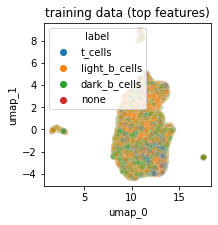

In [15]:
umpa_cord = plot_feature_space(data = filtered_nuc_feat,
                             labels = cell_type,
                             mode="umap",
                             figsize=[3, 3],
                             title="training data (top features)",
                             alpha=0.2)

Text(0.5, 1.0, 'Different images')

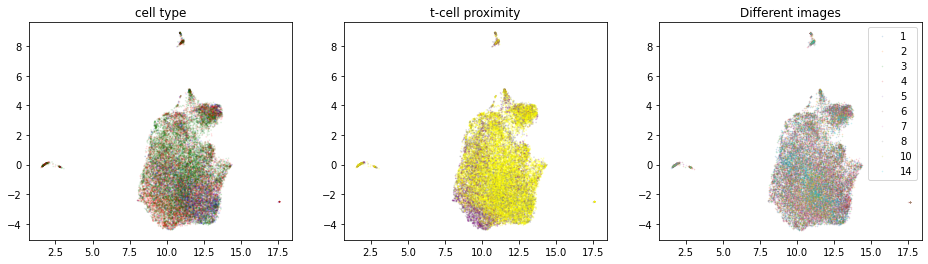

In [16]:
fig = plt.figure(figsize=(16, 4))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)
colors = {'dark_b_cells':'red', 'light_b_cells':'green', 't_cells':'blue', 
          'within_t_cell_zone':'yellow', 'outside_t_cell_zone':'purple',
          'none':'gray'}

ax0.scatter(umpa_cord['umap_0'],umpa_cord['umap_1'], 
                  c=(cell_type.map(colors)),s=0.5,alpha=0.1)
ax0.set_title("cell type")

ax1.scatter(umpa_cord['umap_0'],umpa_cord['umap_1'], 
                  c=(t_cell_proximity.map(colors)),s=0.5,alpha=0.2)
ax1.set_title("t-cell proximity")

umpa_cord['image'] = nuc_features.loc[filtered_nuc_feat.index, "image"]
groups = umpa_cord.groupby('image')
for name, group in groups:
    ax2.plot(group.umap_0, group.umap_1, marker='o', linestyle='', ms=0.5, label=name, alpha = 0.2)
ax2.legend()
ax2.set_title("Different images")


Selected GMM: full model, 2 components


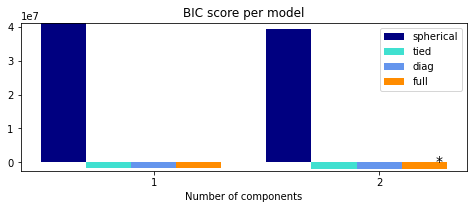

In [17]:
X = filtered_nuc_feat

lowest_bic = np.infty
bic = []
n_components_range = range(1, 3)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)
print(f"Selected GMM: {best_gmm.covariance_type} model, "f"{best_gmm.n_components} components")

Text(0.5, 1.0, 'Different clusters')

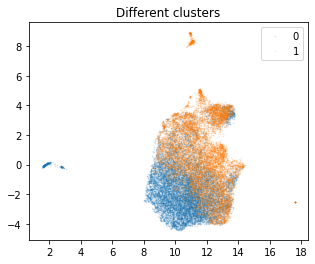

In [18]:
gm = mixture.GaussianMixture(n_components=best_gmm.n_components, covariance_type=best_gmm.covariance_type)
model = gmm.fit(X)
umpa_cord['cluster']  = model.predict(X)
fig = plt.figure(figsize=(5, 4))
ax0 = fig.add_subplot(111)
groups = umpa_cord.groupby('cluster')
for name, group in groups:
    ax0.plot(group.umap_0, group.umap_1, marker='o', linestyle='', ms=0.5, label=name, alpha = 0.2)
ax0.legend()
ax0.set_title("Different clusters")